In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Kalman filtering -  some case studies

In this notebook we will look at a few simplified cases of Kalman filtering.

## Estimating the trajectory of a ball
In the following we will develop a script to estimate the state of a thrown ball (position and velocity). The ball is pulled downwards by gravity and observed using a position sensor (assume some kind of image-recognition algorithm) perturbed by random Gaussian noise.

The state of the system evolves according to the following discrete-time linear equations:

$$ \vec{x}(t+1) = \vec{x}(t) + \Delta t \vec{v}(t) $$
$$ \vec{v}(t+1) = \vec{v}(t) + \Delta t \vec{g} $$

where $\vec{x} = (x,y)$ is the position vector, $\vec{v} = (\dot{x}, \dot{y})$ is the velocity vector and $\vec{g} = (0,g)$ is the gravitational force. Appending the position and velocity vectors together we can write the system evolution equation as

$$\begin{bmatrix}
           x_k \\
           y_k \\
           \dot{x}_k \\
           \dot{y}_k
         \end{bmatrix} = 
         \begin{bmatrix}
         1 & 0 & \Delta t & 0 \\
         0 & 1 & 0 & \Delta t \\
         0 & 0 & 1 & 0 \\
         0 & 0 & 0 & 1
         \end{bmatrix} \cdot \begin{bmatrix}
           x_{k-1} \\
           y_{k-1} \\
           \dot{x}_{k-1} \\
           \dot{y}_{k-1}
         \end{bmatrix} + \begin{bmatrix}
         1 & 0 & 0 & 0 \\
         0 & 1 & 0 & 0 \\
         0 & 0 & 1 & 0 \\
         0 & 0 & 0 & \Delta t
         \end{bmatrix} \cdot
         \begin{bmatrix}
           0 \\
           0 \\
           0 \\
           g
         \end{bmatrix} + \vec{w}_k
         $$
         
 or more compactly as $$\vec{s}_k = \boldsymbol{A}\vec{s}_{k-1} + \boldsymbol{B}\vec{u}_k + \vec{w}_k$$ where $\vec{s}_k = \begin{bmatrix} x_k & y_k & \dot{x}_k & \dot{y}_k\end{bmatrix}^T$ is the internal state vector.
 
Since we are measuring the position we can also write the following observation equation:

$$\vec{z}_k = 
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix} \cdot
\begin{bmatrix}
           x_k \\
           y_k \\
           \dot{x}_k \\
           \dot{y}_k
         \end{bmatrix} + \vec{v}_k
$$
or more compactly as $$\vec{z}_k = \boldsymbol{C}\vec{s}_k + \vec{v}_k$$
The process and measurement noise, $\vec{w}_k$ and $\vec{v}_k$ are assumed to obey Gaussian distribution functions.

## The real trajectory

For the "real" trajectory we advance the system using a very small time-step. In code this looks something like follows:

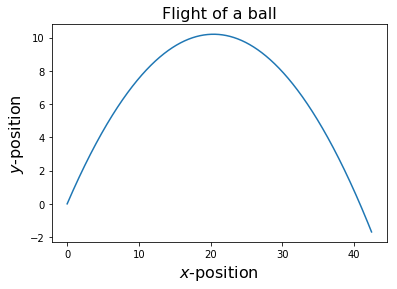

In [4]:
# gravitational force
g = 9.81

# time steps
ts = 1./1000 # 1000 Hz
time = np.arange(0,3,ts)

# state matrix
A = np.diag(np.ones(4))+np.diag(ts*np.ones(2),2)

# input-to-state matrix
B = np.eye(4); B[-1,-1] = ts

# input
u = np.asarray([0,0,0,-g])

# state-to-output matrix
C = np.array([[1,0,0,0],[0,1,0,0]])

              
# state and measurement arrays
x = np.empty((4,len(time)))
y = np.empty((2,len(time)))

# inital state
v0 = 20 # initial velocity
alpha = np.pi/4. # angle at which we throw
x[:,0] = np.asarray([0,0,v0*np.cos(alpha),v0*np.sin(alpha)])
y[:,0] = x[0:2,0]

# simulation
for i in range(1,len(time)):
    x[:,i] = A.dot(x[:,i-1]) + B.dot(u)
    y[:,i] = C.dot(x[:,i])

real_trajectory = y
plt.plot(real_trajectory[0,:],real_trajectory[1,:],'-',label="real trajectory")
plt.xlabel(r"$x$-position",fontsize=16)
plt.ylabel(r"$y$-position",fontsize=16)
plt.title("Flight of a ball",fontsize=16)
plt.show()


## Measurements

For the measurement data we will take the "real" data and perturb it with some Gaussian noise. In reality the measurements would be obtained from our camera system and algorithms estimating the flight of the ball.

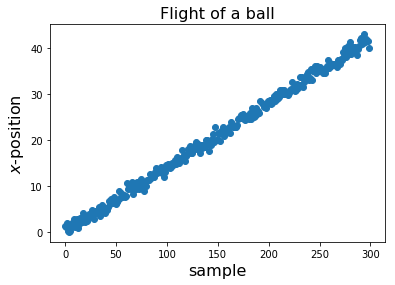

In [5]:
observation_noise = 0.8
measurements = y[0,::10] + np.random.normal(0,observation_noise,y[0,::10].shape)

plt.plot(measurements[:],'o',label="measurements")
plt.xlabel(r"sample",fontsize=16)
plt.ylabel(r"$x$-position",fontsize=16)
plt.title("Flight of a ball",fontsize=16)
plt.show()

## The filtered trajectory

For the filtered trajectory we choose a filter rate matching the frequency of measurements and once again setup the state and input-to-state matrices:

In [6]:
ts = 1./100 # 100 Hz
ftime = np.arange(0,3,ts)

A = np.diag(np.ones(4))+np.diag(ts*np.ones(2),2)
B = np.eye(4); B[-1,-1] = ts
C = np.array([1,0,0,0])
print(A)
print(B)
print(u)

[[1.   0.   0.01 0.  ]
 [0.   1.   0.   0.01]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]]
[[1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   0.01]]
[ 0.    0.    0.   -9.81]


Next we require an estimate of the initial position and its covariance:

In [7]:
xf = np.empty((4,len(ftime)))
yf = np.empty((2,len(ftime)))

x_init = np.array([0.,10.,1.,1.])
xf[:,0] = x_init

Additionally we need to initialize the covariance of the estimation error as well as the modeling and error noise covariance matrices:

In [8]:
evolution_noise = 0.01
Q = evolution_noise*np.eye(4)
P = A.dot(np.eye(4).dot(A.T))
R = observation_noise*np.eye(1)

Finally, we can step the filtered system forward in time:

In [9]:
for i in range(1,len(ftime)):

    # Prediction step
    # ---------------------
    # Project state and error covariance
    xtemp = A.dot(xf[:,i-1]) + B.dot(u)
    P = A.dot(P).dot(A.T) + Q

    # Correction step
    # ---------------------
    # Compute Kalman gain
    K = P.dot(C).dot(np.linalg.pinv(C.dot(P).dot(C) + R))
    # Update estimate via measurement
    xf[:,i] = xtemp + K.dot(measurements[i] - C.dot(xtemp))
    # Update error covariance
    P = P - K.dot(C).dot(P)

ValueError: shapes (4,) and (1,1) not aligned: 4 (dim 0) != 1 (dim 0)

The only remaining step is now to plot the filtered and measured outputs for comparison:

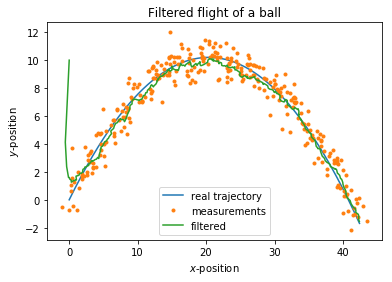

In [21]:
plt.plot(real_trajectory[0,:],real_trajectory[1,:],'-',label="real trajectory")
plt.plot(measurements[0,:],measurements[1,:],'.',label="measurements")
plt.plot(xf[0,:],xf[1,:],'-',label="filtered")

plt.title("Filtered flight of a ball")
plt.xlabel(r"$x$-position")
plt.ylabel(r"$y$-position")
plt.legend(loc=0)
plt.show()